# Predictive modelling of attrition data using Python SkLearn

In [1]:
# data manipulation libraries
import numpy as np
import pandas as pd

# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# machine learning tools
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
import time

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

In [2]:
# loading the dataset into a dataframe
attrition_df= pd.read_csv('attrition_df.csv')
print(attrition_df.shape)
print(attrition_df.columns)
print(attrition_df.dtypes)
attrition_df.sample(5)

(1999999, 12)
Index(['ee#', 'age', 'department', 'province', 'level', 'tenure',
       'previous_xp', 'total_xp', 'gender', 'ethnicity', 'hire_source',
       'promotion'],
      dtype='object')
ee#              int64
age              int64
department      object
province        object
level           object
tenure         float64
previous_xp    float64
total_xp       float64
gender          object
ethnicity       object
hire_source     object
promotion       object
dtype: object


,ee#,age,department,province,level,tenure,previous_xp,total_xp,gender,ethnicity,hire_source,promotion
1507317,11507318,46,Customer Service,British Columbia,Manager/Director,13.3,2.1,15.4,female,caucasian,direct,not_promoted
1478361,11478362,35,Marketing,Nova Scotia,Manager/Director,0.0,13.8,13.8,female,caucasian,direct,not_promoted
1645286,11645287,48,Sales,Saskatchewan,Manager/Director,17.0,6.0,23.0,female,hispanic,referral,promoted
1641801,11641802,64,HR,Northwest Territories,Individual contributor,2.0,11.7,13.7,female,hispanic,referral,not_promoted
1734380,11734381,54,Legal,New Brunswick,Individual contributor,6.3,4.6,10.9,female,caucasian,direct,promoted


## Dataframe preparation

In [3]:
# creating a value to be predicted
# initializing target variable with ratio 80/20
np.random.seed(4)
num_samples= len(attrition_df)
status = np.random.choice(a= ['active', 'left'],
                          size= num_samples,
                          p= [0.6, 0.4])

# introducing subtle patterns in the data
for i in range(num_samples):
    if attrition_df['department'][i] == 'Project Management':
        status[i] = 'left' if np.random.rand() < 0.30 else status[i]
    if attrition_df['age'][i] > 50:
        status[i] = 'left' if np.random.rand() < 0.30 else status[i]
    if attrition_df['hire_source'][i] == 'direct':
        status[i] = 'left' if np.random.rand() < 0.30 else status[i]
    if attrition_df['province'][i] == 'Alberta':
        status[i] = 'left' if np.random.rand() < 0.30 else status[i]

attrition_df['status'] = status
attrition_df.sample(5)

,ee#,age,department,province,level,tenure,previous_xp,total_xp,gender,ethnicity,hire_source,promotion,status
1759929,11759930,63,Sales,Nunavut,Manager/Director,21.0,5.0,26.0,female,caucasian,referral,not_promoted,left
1167069,11167070,48,Finance,Nova Scotia,Manager/Director,4.9,18.1,23.0,female,caucasian,direct,not_promoted,active
765751,10765752,34,HR,Northwest Territories,Manager/Director,0.0,9.0,9.0,female,caucasian,direct,promoted,left
1986474,11986475,61,Project Management,Quebec,Manager/Director,19.4,16.6,36.0,female,caucasian,referral,not_promoted,left
1039172,11039173,40,Legal,Yukon Territory,Manager/Director,1.6,13.4,15.0,female,caucasian,referral,promoted,active


The target is initialized with a 60/40 ratio to provide both enough active and left cases to the model. 
The patterns introduced in the data are so that if any of the below conditions is met, the status 'left' is 30% likely to occur:
- Employees in 'Project Management'
- Employees above 50
- Employees hired directly
- Employees in Alberta

In [4]:
# breaking down the dataframe into individual predictors
attr_dummy_df= pd.get_dummies(data= attrition_df,
                             dtype= 'float64')
attr_dummy_df= attr_dummy_df.drop(columns=['status_left','promotion_not_promoted'],
                                  axis=1)
attr_dummy_df= attr_dummy_df.rename(columns={'promotion_promoted':'promotion',
                                             'status_active':'status'})
attr_dummy_df.sample(5)

,ee#,age,tenure,previous_xp,total_xp,department_Customer Service,department_Finance,department_HR,department_IT,department_Legal,...,level_Individual contributor,level_Manager/Director,gender_female,ethnicity_asian,ethnicity_caucasian,ethnicity_hispanic,hire_source_direct,hire_source_referral,promotion,status
745340,10745341,63,8.1,7.8,15.9,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1819063,11819064,62,14.1,22.9,37.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
650038,10650039,67,10.0,20.8,30.8,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1127691,11127692,40,17.3,0.0,17.3,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
407412,10407413,51,12.6,13.4,26.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


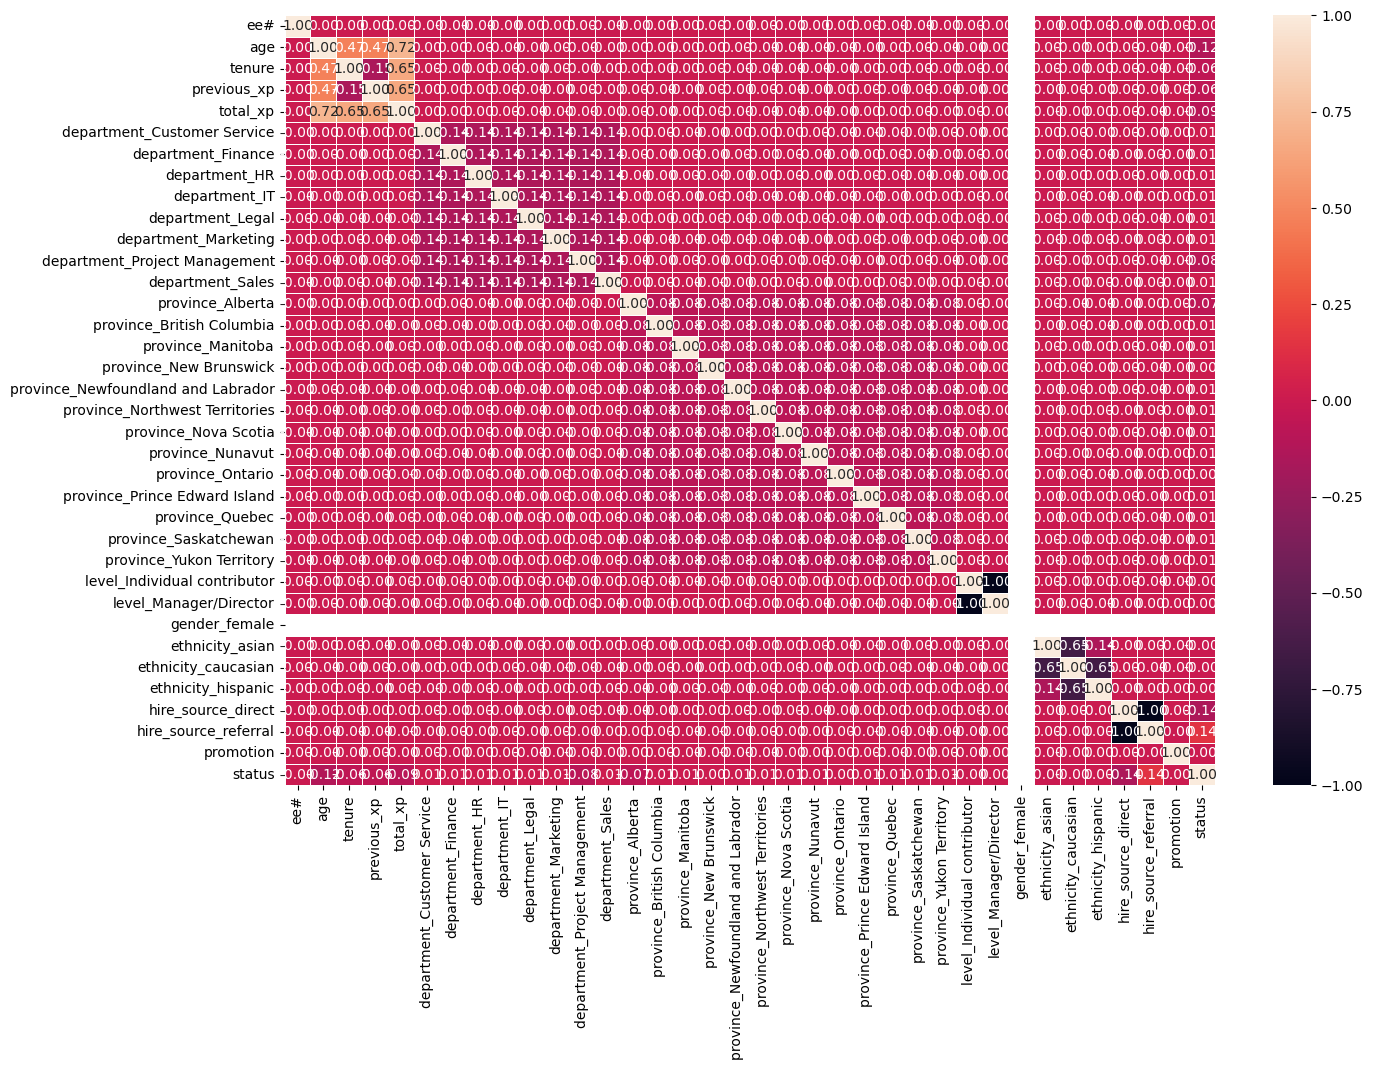

In [5]:
# correlation matrix
attr_corr_matrix= attr_dummy_df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(attr_corr_matrix, 
            annot= True,
            linewidths= 0.5,
            fmt= ".2f")
plt.show()

## Data splitting and model initializations

In [6]:
# separating target variables from features with patterns
X_dept= pd.DataFrame(attr_dummy_df['department_Project Management'])
X_age= pd.DataFrame(attr_dummy_df['age'])
X_source= pd.DataFrame(attr_dummy_df['hire_source_direct'])
X_province= pd.DataFrame(attr_dummy_df['province_Alberta'])

y= attr_dummy_df['status']

In [7]:
# splitting department predictor into train vs test data
X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y, 
                                                    train_size= 0.7,
                                                    test_size= 0.3,
                                                    random_state= 4)

# splitting age predictor into train vs test data
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X_age, y, 
                                                    train_size= 0.7,
                                                    test_size= 0.3,
                                                    random_state= 4)

# splitting source predictor into train vs test data
X_train_source, X_test_source, y_train_source, y_test_source = train_test_split(X_source, y, 
                                                    train_size= 0.7,
                                                    test_size= 0.3,
                                                    random_state= 4)

# splitting province predictor into train vs test data
X_train_province, X_test_province, y_train_province, y_test_province = train_test_split(X_province, y, 
                                                    train_size= 0.7,
                                                    test_size= 0.3,
                                                    random_state= 4)

In [8]:
# initializing models
regular_models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB()
}

ensemble_models = {
    'Random Forest': RandomForestClassifier(),
    'SVM-linear': svm.SVC(kernel='linear'),
    'SVM-RBF': svm.SVC(kernel='rbf')
}

In [9]:
# train, test and evaluate
def train_eval_models(models, X_train, X_test, y_train, y_test):
    model_scores = []

    for name, model in models.items():
        model_info = {}
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        train_accuracy = accuracy_score(y_true= y_train,
                                        y_pred= y_pred_train)
        test_accuracy = accuracy_score(y_true= y_test,
                                       y_pred= y_pred_test)
        model_info['name'] = name
        model_info['train_accuracy'] = f'{train_accuracy *100:.2f}%'
        model_info['test_accuracy'] = f'{test_accuracy *100:.2f}%'
        model_scores.append(model_info)
        
    return pd.DataFrame(model_scores)

In [10]:
# running the prediction for dept
reg_model_scores_dept = train_eval_models(regular_models,
                                           X_train_dept, 
                                           X_test_dept, 
                                           y_train_dept, 
                                           y_test_dept)
reg_model_scores_dept

,name,train_accuracy,test_accuracy
0,Logistic Regression,60.69%,60.74%
1,Decision Tree,60.69%,60.74%
2,Naive Bayes,60.69%,60.74%


In [11]:
# running the prediction for age
reg_model_age = train_eval_models(regular_models,
                                  X_train_age,
                                  X_test_age,
                                  y_train_age,
                                  y_test_age)
reg_model_age

,name,train_accuracy,test_accuracy
0,Logistic Regression,60.69%,60.74%
1,Decision Tree,60.69%,60.74%
2,Naive Bayes,60.69%,60.74%


In [12]:
# running the prediction for province
reg_model_province = train_eval_models(regular_models,
                                  X_train_province,
                                  X_test_province,
                                  y_train_province,
                                  y_test_province)
reg_model_province

,name,train_accuracy,test_accuracy
0,Logistic Regression,60.69%,60.74%
1,Decision Tree,60.69%,60.74%
2,Naive Bayes,60.69%,60.74%


In [13]:
# running the prediction for hire source
reg_model_source = train_eval_models(regular_models,
                                  X_train_source,
                                  X_test_source,
                                  y_train_source,
                                  y_test_source)
reg_model_source

,name,train_accuracy,test_accuracy
0,Logistic Regression,60.69%,60.74%
1,Decision Tree,60.69%,60.74%
2,Naive Bayes,60.05%,60.07%
